In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [4]:
!pip install Pillow
!pip install matplotlib
!pip install opencv-python

In [58]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np

In [59]:
from transformers.utils import send_example_telemetry
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from transformers.image_utils import ImageFeatureExtractionMixin

In [60]:
send_example_telemetry("zeroshot_object_detection_with_owlvit_notebook", framework="pytorch")

In [61]:
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

In [113]:
image_path = "/Users/priyanshutuli/Desktop/Planogram_Optimization/Baseline_Images/images/D972B87F-4A1E-4357-9781-3D2B9FB19E28_IMG_1371.jpeg"

In [114]:
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

In [115]:
image

array([[[121, 116,  96],
        [118, 113,  93],
        [123, 116,  97],
        ...,
        [102,  94,  71],
        [ 97,  89,  66],
        [ 98,  90,  67]],

       [[128, 123, 103],
        [127, 122, 102],
        [121, 114,  95],
        ...,
        [ 97,  89,  66],
        [ 91,  83,  60],
        [ 98,  90,  67]],

       [[128, 123, 103],
        [122, 117,  97],
        [117, 110,  91],
        ...,
        [ 91,  83,  62],
        [ 84,  76,  53],
        [ 95,  87,  64]],

       ...,

       [[ 52,  45,  29],
        [ 52,  45,  29],
        [ 59,  50,  33],
        ...,
        [150, 143, 133],
        [151, 144, 134],
        [153, 146, 136]],

       [[ 53,  46,  30],
        [ 49,  42,  26],
        [ 55,  46,  29],
        ...,
        [146, 139, 129],
        [146, 139, 129],
        [152, 145, 135]],

       [[ 46,  39,  23],
        [ 47,  40,  24],
        [ 49,  40,  23],
        ...,
        [147, 140, 130],
        [147, 140, 130],
        [145, 138, 128]]

In [177]:
text_queries = ["price tag", "price", "price label"]

In [178]:
device = "cpu"

## Zero Shot Inference

In [179]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([3, 16])
attention_mask: torch.Size([3, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [180]:
# Set model in evaluation mode
model = model.to(device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 3])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 3, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([3, 16, 512])
pooler_output: shape of torch.Size([3, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [187]:
mixin = ImageFeatureExtractionMixin()

image_size = model.config.vision_config.image_size
resized_image = mixin.resize(image, image_size)
input_image = np.asarray(resized_image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.01

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

In [188]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

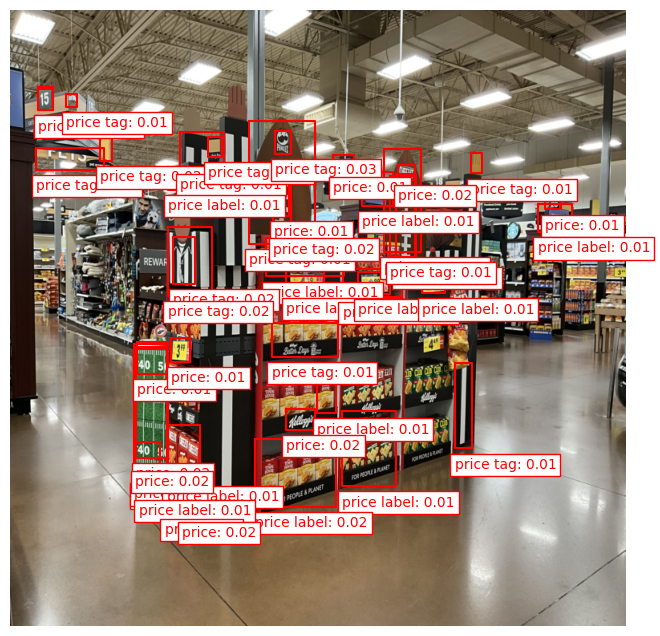

In [189]:
plot_predictions(input_image, text_queries, scores, boxes, labels)

## One Shot Inference (Image Guided Technique)

In [141]:
query_image_path = "/Users/priyanshutuli/Desktop/Planogram_Optimization/datasets/pricetags/train/images/10_jpg.rf.0729882ee6621a56c9ffe06a91b4d67a.jpg"

In [142]:
query_image = cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB)

In [168]:
# Process input and query image
inputs = processor(images=image, query_images=[query_image], return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [169]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [170]:
target_sizes = torch.Tensor([image.shape[0:2]])

In [171]:
target_sizes

tensor([[3024., 4032.]])

In [172]:
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu() 

In [173]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

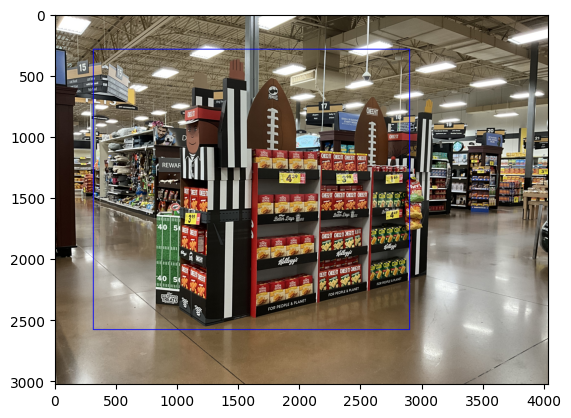

In [176]:
results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25 
        
plt.imshow(img[:,:,::-1])
plt.show()


In [194]:
from transformers import AutoFeatureExtractor
from transformers import AutoTokenizer
from transformers import OwlViTProcessor, OwlViTForObjectDetection, OwlViTFeatureExtractor

In [191]:
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from transformers import TrainingArguments, Trainer
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor

In [195]:
feature_extractor = OwlViTFeatureExtractor.from_pretrained("google/owlvit-base-patch32")

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

tokenizer = AutoTokenizer.from_pretrained("google/owlvit-base-patch32")

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

/Users/priyanshutuli/Desktop/Planogram_Optimization/.venv/lib/python3.10/site-packages/transformers/models/owlvit/feature_extraction_owlvit.py:28: FutureWarning: The class OwlViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use OwlViTImageProcessor instead.
  warnings.warn(
